<a href="https://colab.research.google.com/github/lamtung1997/Solving_PDEs_Deep_learning/blob/main/2_Stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# SETUP
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import time
import math
import itertools
import os
import logging
from numpy import loadtxt
import matplotlib.pyplot as plt

# number pi
pi = math.pi

# STOP WARNING
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)

# random_seed
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
# DATA

n = 50                      # number of points in a border
c = np.linspace(0, 1, n)    # coordinates from 0 to 1 with uniform distribution
P_in, P_up, P_b = [], [], []
for i, j in itertools.product(range(n), range(n)):
    p = [c[i], c[j]]
    if(j == n-1 and i != 0 and i != n-1):
        P_up.append(p)
    elif(i == 0 or i == n-1 or j == 0):
        P_b.append(p)
    else:
        P_in.append(p)

# upsampling P_up that its size is equal to P_in
for i in range(len(P_in)-len(P_up)):
    j = i%(len(P_up))
    P_up.append(P_up[j])

# upsampling P_b that its size is equal to P_in
for i in range(len(P_in)-len(P_b)):
    j = i%(len(P_b))
    P_b.append(P_b[j])

# convert numpy array, P_in and P_border to Tensorflow Dataset
P_in = tf.convert_to_tensor(P_in, dtype=tf.float32)
P_up = tf.convert_to_tensor(P_up, dtype=tf.float32)
P_b = tf.convert_to_tensor(P_b, dtype=tf.float32)

batch_size = 1
bs = int(len(P_in))

P_in = tf.data.Dataset.from_tensor_slices((P_in))
P_in = P_in.shuffle(buffer_size=bs).batch(batch_size)

P_up = tf.data.Dataset.from_tensor_slices((P_up))
P_up = P_up.shuffle(buffer_size=bs).batch(batch_size)

P_b = tf.data.Dataset.from_tensor_slices((P_b))
P_b = P_b.shuffle(buffer_size=bs).batch(batch_size)

In [3]:
print("Number of data:", P_up.cardinality().numpy()*batch_size*3)

Number of data: 6912


In [4]:
# MODEL
nn = 16
inputs = keras.Input(shape=(2,), name='points')
hidden_1 = layers.Dense(nn, activation='tanh', name='hidden_1')(inputs)
# hidden_2 = layers.Dense(nn, activation='tanh', name='hidden_2')(hidden_1)
# hidden_3 = layers.Dense(nn, activation='tanh', name='hidden_3')(hidden_2)
# hidden_4 = layers.Dense(nn, activation='tanh', name='hidden_4')(hidden_3)
# hidden_5 = layers.Dense(nn, activation='tanh', name='hidden_5')(hidden_4)
# hidden_6 = layers.Dense(nn, activation='tanh', name='hidden_6')(hidden_5)
# hidden_7 = layers.Dense(nn, activation='tanh', name='hidden_7')(hidden_6)
# hidden_8 = layers.Dense(nn, activation='tanh', name='hidden_8')(hidden_7)
outputs = layers.Dense(3, activation='linear', name="u_v_p")(hidden_1)
model = keras.Model(inputs=inputs, outputs=outputs, name='stokes')
model.summary()

Model: "stokes"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
points (InputLayer)          [(None, 2)]               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 16)                48        
_________________________________________________________________
u_v_p (Dense)                (None, 3)                 51        
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________


In [5]:
# CHOOSE OPTIMIZER
optimizer = tf.keras.optimizers.Adam()

In [6]:
# TRAIN FUNCTION
@tf.function
def train_step(P_in, P_up, P_b):
    with tf.GradientTape(persistent=True) as tape:
        loss_in, loss_up, loss_b = [0], [0], [0]

        # interior loss
        for i in range(P_in.shape[0]):
            z = tf.reshape(P_in[i], shape=(1,2))
            tape.watch(z)
            model_vals = model(z)

            # calculating u_xx, u_yy, v_xx, v_yy, p_x, p_y
            u = model_vals[0][0]
            v = model_vals[0][1]
            p = model_vals[0][2]

            u_x = tape.gradient(u, z)[0][0]
            u_xx = tape.gradient(u_x, z)[0][0]
            u_y = tape.gradient(u, z)[0][1]
            u_yy = tape.gradient(u_y, z)[0][1]
            
            v_x = tape.gradient(v, z)[0][0]
            v_xx = tape.gradient(v_x, z)[0][0]
            v_y = tape.gradient(v, z)[0][1]
            v_yy = tape.gradient(v_y, z)[0][1]

            p_x = tape.gradient(p, z)[0][0]
            p_y = tape.gradient(p, z)[0][1]

            # calculating loss_in
            loss1 = tf.math.square(u_xx + u_yy - p_x)
            loss2 = tf.math.square(v_xx + v_yy - p_y)
            loss3 = tf.math.square(u_x + v_y)
            loss_in += loss1 + loss2 + loss3

        # upper boundary loss
        for j in range(P_up.shape[0]):
            z = tf.reshape(P_up[j], shape=(1,2))
            tape.watch(z)
            model_vals = model(z)

            # calculating u,v
            u = model_vals[0][0]
            v = model_vals[0][1]

            # calculating loss_up
            loss_up += tf.math.square(u-1) + tf.math.square(v)

        # other boundaries loss
        for j in range(P_b.shape[0]):
            z = tf.reshape(P_b[j], shape=(1,2))
            tape.watch(z)
            model_vals = model(z)

            # calculating u,v
            u = model_vals[0][0]
            v = model_vals[0][1]

            # calculating loss_up
            loss_b += tf.math.square(u) + tf.math.square(v)
        
        # loss function
        # batch_loss = (loss_in+loss_up+loss_b) + 0.1*(tf.math.square(loss_in-loss_up) + tf.math.square(loss_b-loss_in))
        batch_loss = loss_in + loss_up + loss_b
    
    # update weights
    grads = tape.gradient(batch_loss, model.trainable_weights)          # gradient of loss function with respect to w
    optimizer.apply_gradients(zip(grads, model.trainable_weights))      # update w

    return batch_loss

In [7]:
# TRAIN
losses = []
def train(learning_rate):
    optimizer.learning_rate.assign(learning_rate)
    loss = 0
    for (P_in_batch, P_up_batch, P_b_batch) in itertools.zip_longest(P_in, P_up, P_b):
        batch_loss = train_step(P_in_batch, P_up_batch, P_b_batch)
        loss += batch_loss
    losses.append(loss.numpy())

In [8]:
# TRAIN
i = 0
max_ite = 1000
lr = 1e-3
start = time.time()
print("Learning rate:", lr)
while(True):
    start_ite = time.time()
    train(lr)
    if(i%1 == 0):
        print("[%3s] loss = %13.7f \t %5.3fs \t less than %5.3f minutes to finish" % (i, losses[i], time.time() - start_ite, (time.time() - start_ite)*(max_ite - i)/60))
    if(i > 200):
        if(losses[i]/np.min(losses[i - 200 : i - 100]) > 0.96):
            lr = lr/10
            if(lr < 1e-4):
                break
            print("\nNew learning rate:", lr)
    if(i > max_ite):
        break
    i = i + 1


print("Total time: %.2f minutes" % ((time.time() - start)/60))

Learning rate: 0.001
[  0] loss =   505.6080627 	 3.789s 	 less than 63.150 minutes to finish
[  1] loss =   394.5455322 	 2.236s 	 less than 37.229 minutes to finish
[  2] loss =   384.1852722 	 2.186s 	 less than 36.361 minutes to finish
[  3] loss =   375.4322815 	 2.140s 	 less than 35.561 minutes to finish
[  4] loss =   369.1172791 	 2.199s 	 less than 36.509 minutes to finish
[  5] loss =   365.8886108 	 2.232s 	 less than 37.015 minutes to finish
[  6] loss =   362.7929077 	 2.231s 	 less than 36.961 minutes to finish
[  7] loss =   361.1975098 	 2.165s 	 less than 35.829 minutes to finish
[  8] loss =   359.9676208 	 2.196s 	 less than 36.315 minutes to finish
[  9] loss =   358.1219788 	 2.155s 	 less than 35.598 minutes to finish
[ 10] loss =   356.0070496 	 2.151s 	 less than 35.498 minutes to finish
[ 11] loss =   353.8283081 	 2.221s 	 less than 36.604 minutes to finish
[ 12] loss =   352.2500610 	 2.194s 	 less than 36.125 minutes to finish
[ 13] loss =   351.4222717 	 2

In [9]:
model.save("/content/drive/My Drive/Colab Notebooks/Keras/Solving PDEs/2. Stokes (generated data)")

In [10]:
model1 = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/Keras/Solving PDEs/2. Stokes (generated data)")

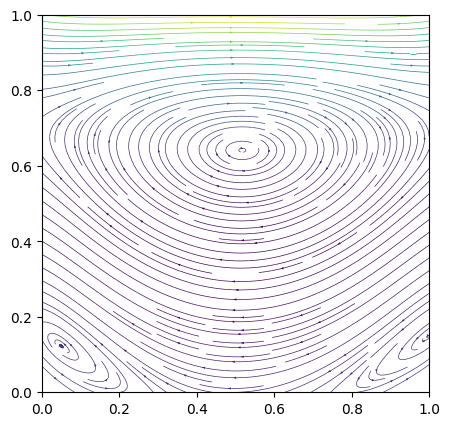

In [12]:
plt.figure(figsize=(5, 5), dpi=100)

n = 20
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)

u = np.zeros(shape=(n,n), dtype=float)
v = np.zeros(shape=(n,n), dtype=float)

for i in range(n):
    for j in range(n):
        z = tf.convert_to_tensor([[x[i], y[j]]])
        u1, v1 = model1(z).numpy()[0][0:2]
        u[j,i] = u1
        v[j,i] = v1

plt.streamplot(x, y, u, v, color=u*10, linewidth=0.5, arrowsize=0.25, density=2)
plt.show()